In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
PATH = f'../data/connectomes/brain_graph/'
DATASET = f'repeated_10_scale_60'

files = os.listdir(PATH+DATASET)

In [4]:
# Read the first 10 graphml files
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:10]]

# Create a list of graphs
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:10]]

In [5]:
def visualize_first_n_graphs(graphs, n=10, figsize=(15, 10), node_size=300, font_size=8, edge_width=0.5):
    """
    Visualize the first n graphs in a publication-ready format.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n : int
        Number of graphs to visualize
    figsize : tuple
        Figure size (width, height)
    node_size : int
        Size of nodes in the visualization
    font_size : int
        Font size for node labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Limit n to available graphs
    n = min(n, len(graphs))
    
    # Calculate grid dimensions
    cols = min(4, n)  # Maximum 4 columns
    rows = (n + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle single subplot case
    if n == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # Color scheme for publication quality
    node_color = '#4472C4'  # Professional blue
    edge_color = '#8B8B8B'  # Subtle gray
    
    for i in range(n):
        G = graphs[i]
        ax = axes[i]
        
        # Use spring layout for consistent positioning
        pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
        
        # Draw edges first (so they appear behind nodes)
        nx.draw_networkx_edges(G, pos, ax=ax, 
                              edge_color=edge_color, 
                              width=edge_width, 
                              alpha=0.6)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax,
                              node_color=node_color,
                              node_size=node_size,
                              alpha=0.8)
        
        # Set title and remove axes
        ax.set_title(f'Graph {i+1}\n({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)',
                    fontsize=font_size+2, fontweight='bold', pad=10)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    # Adjust layout for publication quality
    plt.tight_layout(pad=2.0)
    
    # Add overall title
    #fig.suptitle(f'Brain Connectome Graphs (First {n} samples)\n\n', 
    #            fontsize=16, fontweight='bold', y=0.98)
    
    return fig


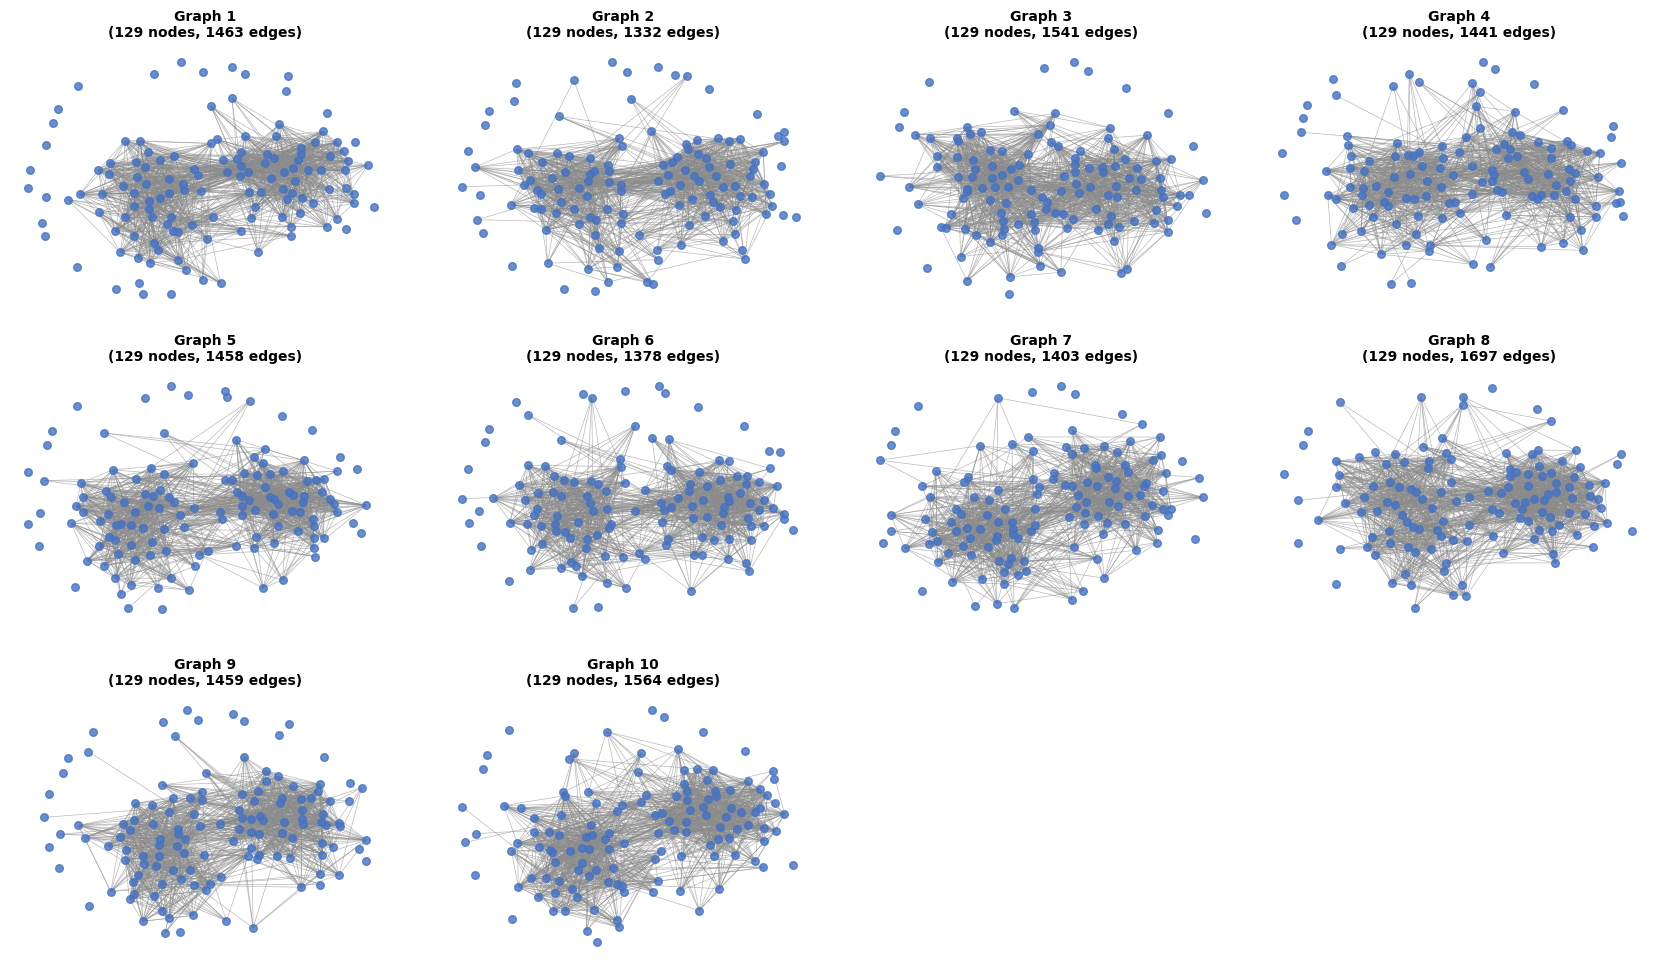

In [6]:
fig = visualize_first_n_graphs(graphs, n=10, figsize=(17, 10), node_size=30, font_size=8, edge_width=0.5)

# Model LG fitting

In [7]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        # warm_up=warm_up,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs



In [8]:
def visualize_original_vs_fitted_graphs(results, figsize=(20, 12), node_size=30, font_size=8, edge_width=0.5):
    """
    Visualize original graphs vs fitted LG graphs with GIC values.
    
    Parameters:
    -----------
    results : dict
        Results from fit_logit_graphs_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    n_graphs = len(results['original_graphs'])
    
    # Create subplot grid: 2 rows (original vs fitted), n_graphs columns
    fig, axes = plt.subplots(2, n_graphs, figsize=figsize)
    
    # Handle single graph case
    if n_graphs == 1:
        axes = axes.reshape(2, 1)
    
    # Color schemes
    original_node_color = '#4472C4'  # Blue for original
    fitted_node_color = '#E74C3C'    # Red for fitted
    edge_color = '#8B8B8B'           # Gray for edges
    
    for i in range(n_graphs):
        original_graph = results['original_graphs'][i]
        fitted_graph = results['fitted_graphs'][i]
        gic_value = results['gic_values'][i]
        stats = results['graph_stats'][i]
        
        # Plot original graph (top row)
        ax_orig = axes[0, i]
        pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                              edge_color=edge_color, width=edge_width, alpha=0.6)
        nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                              node_color=original_node_color, node_size=node_size, alpha=0.8)
        
        ax_orig.set_title(f'Original Graph {i+1}\n({stats["original_nodes"]} nodes, {stats["original_edges"]} edges)',
                         fontsize=font_size+2, fontweight='bold', pad=10)
        ax_orig.axis('off')
        
        # Plot fitted graph (bottom row)
        ax_fitted = axes[1, i]
        
        if fitted_graph is not None and results['fit_success'][i]:
            pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted,
                                  node_color=fitted_node_color, node_size=node_size, alpha=0.8)
            
            title = f'Fitted LG Graph {i+1}\n({stats["fitted_nodes"]} nodes, {stats["fitted_edges"]} edges)\nGIC: {gic_value:.4f}'
        else:
            title = f'Fitted LG Graph {i+1}\n(Fitting Failed)'
        
        ax_fitted.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_fitted.axis('off')
    
    # Add overall title
    fig.suptitle('Original Brain Connectomes vs Fitted Logit Graph Models', 
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    return fig


In [9]:
def fit_logit_graphs_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing original graphs, fitted graphs, and GIC values
    """
    if sim_params is None:
        sim_params = {
            "d": 0,
            "n_iteration": 10000,  # Reduced for faster computation
            "warm_up": 500,
            "patience": 2000,
            "dist_type": 'KL',
            "min_gic_threshold": 5,
            "verbose": True,
        }
    
    results = {
        'original_graphs': [],
        'fitted_graphs': [],
        'gic_values': [],
        'fit_success': [],
        'graph_stats': []
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} {'='*20}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        try:
            # Fit logit graph model
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=sim_params["d"],
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=None,  # Use spectrum convergence only
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix = logit_results[0]
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            gic_value = logit_results[2][0]
            best_iteration = logit_results[5]
            
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(fitted_graph)
            results['gic_values'].append(gic_value)
            results['fit_success'].append(True)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': fitted_graph.number_of_nodes(),
                'fitted_edges': fitted_graph.number_of_edges(),
                'best_iteration': best_iteration
            })
            
            print(f"Fitting successful - GIC: {gic_value:.4f}, Best iteration: {best_iteration}")
            print(f"Fitted graph - Nodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}")
            
        except Exception as e:
            print(f"Error fitting graph {i+1}: {e}")
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(None)
            results['gic_values'].append(np.nan)
            results['fit_success'].append(False)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': 0,
                'fitted_edges': 0,
                'best_iteration': 0
            })
        
        gc.collect()  # Clean up memory
    
    return results


In [10]:
def print_fitting_summary(results):
    """Print summary of fitting results."""
    n_graphs = len(results['original_graphs'])
    successful_fits = sum(results['fit_success'])
    
    print(f"\n{'='*50}")
    print(f"LOGIT GRAPH FITTING SUMMARY")
    print(f"{'='*50}")
    print(f"Total graphs processed: {n_graphs}")
    print(f"Successful fits: {successful_fits}/{n_graphs}")
    print(f"Success rate: {successful_fits/n_graphs*100:.1f}%")
    
    if successful_fits > 0:
        valid_gics = [gic for gic, success in zip(results['gic_values'], results['fit_success']) 
                     if success and not np.isnan(gic)]
        if valid_gics:
            print(f"\nGIC Statistics:")
            print(f"  Mean GIC: {np.mean(valid_gics):.4f}")
            print(f"  Std GIC: {np.std(valid_gics):.4f}")
            print(f"  Min GIC: {np.min(valid_gics):.4f}")
            print(f"  Max GIC: {np.max(valid_gics):.4f}")
    
    print(f"\nDetailed Results:")
    for i, (gic, success, stats) in enumerate(zip(results['gic_values'], results['fit_success'], results['graph_stats'])):
        status = "SUCCESS" if success else "FAILED"
        gic_str = f"{gic:.4f}" if success and not np.isnan(gic) else "N/A"
        print(f"  Graph {i+1}: {status} | GIC: {gic_str} | "
              f"Orig: {stats['original_nodes']}n/{stats['original_edges']}e | "
              f"Fitted: {stats['fitted_nodes']}n/{stats['fitted_edges']}e")

In [ ]:
# Define simulation parameters for faster computation on multiple graphs
sim_params = {
    "d": 0,
    "n_iteration": 8000,   # Reduced for faster computation
    "warm_up": 500,
    "patience": 1500,      # Reduced patience
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,
}

# Fit logit graphs to the first 5 graphs
print("Starting logit graph fitting experiment...")
fitting_results = fit_logit_graphs_to_dataset(graphs, n_graphs=5, sim_params=sim_params)

Starting logit graph fitting experiment...

==================== Processing Graph 1/5 ====================
Original graph - Nodes: 129, Edges: 1463
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/1500
	 Current edges: 0.0 (Real edges: 1463.0)
iteration: 1000
	 Current GIC (KL): 14.6830 (Threshold: 5)
	 Best Spectrum Diff: 318.0020
	 Patience: 0/1500
	 Current edges: 8.0 (Real edges: 1463.0)


In [ ]:
# Print summary of results
print_fitting_summary(fitting_results)

In [ ]:
# Create the comparison visualization
fig_comparison = visualize_original_vs_fitted_graphs(
    fitting_results, 
    figsize=(20, 12), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

# Save the figure if needed
#fig_comparison.savefig('../images/original_vs_fitted_lg_graphs.png', dpi=300, bbox_inches='tight')

In [ ]:
312313